Import Library

In [219]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from datetime import datetime, timedelta
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import evaluate

In [176]:
data = pd.read_csv("ticker_data_with_TI.csv")

Remove Unnecessary Feature

In [177]:
# remove name and index

data = data.reset_index(drop=True)
data = data.drop("ticker", axis=1)
data = data.drop("industry", axis=1)

In [178]:
# remove feature that have too high correlation

data = data.drop("open", axis=1)
data = data.drop("high", axis=1)
data = data.drop("low", axis=1)
data = data.drop("MA10", axis=1)
data = data.drop("MA50", axis=1)
data = data.dropna()

<Axes: >

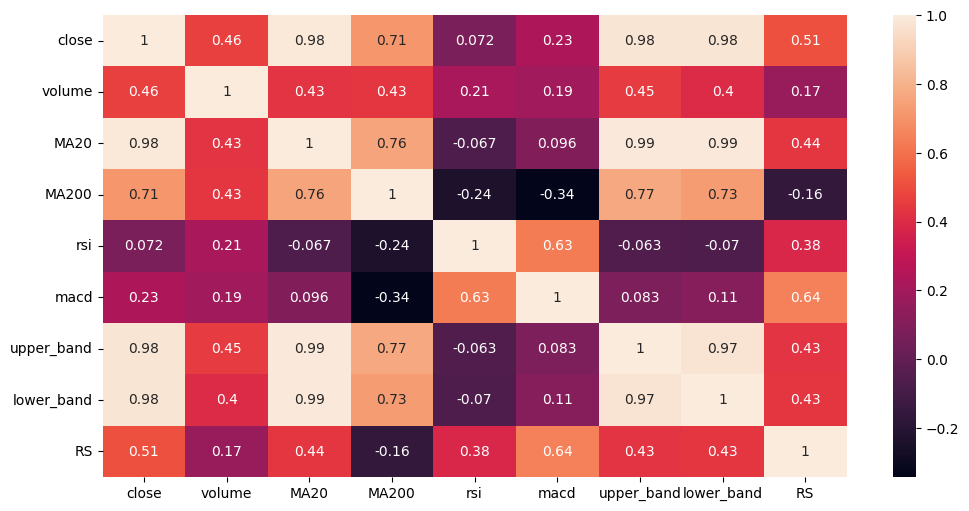

In [179]:
# plot data

data = data.drop("time", axis=1)
plt.figure(figsize=(12, 6))
corrMatrix = data.corr()
sns.heatmap(corrMatrix, annot=True)

In [180]:
data = data.reset_index(drop=True)
data.head()

,close,volume,MA20,MA200,rsi,macd,upper_band,lower_band,RS
0,10240,1399280,10186.5,11370.85,48.466258,69.893454,10760.618088,9612.381912,-11.661495
1,10140,1092380,10199.0,11360.50,36.486486,59.030869,10756.585018,9641.414982,-12.369254
2,10020,1287590,10212.5,11350.05,35.526316,40.274931,10736.367199,9688.632801,-13.420417
3,9880,1386210,10221.0,11338.05,29.559748,13.953042,10715.214954,9726.785046,-14.752619
4,9930,1056960,10225.5,11327.15,26.797386,-2.839924,10706.572267,9744.427733,-13.503353


Split Data Train and Test

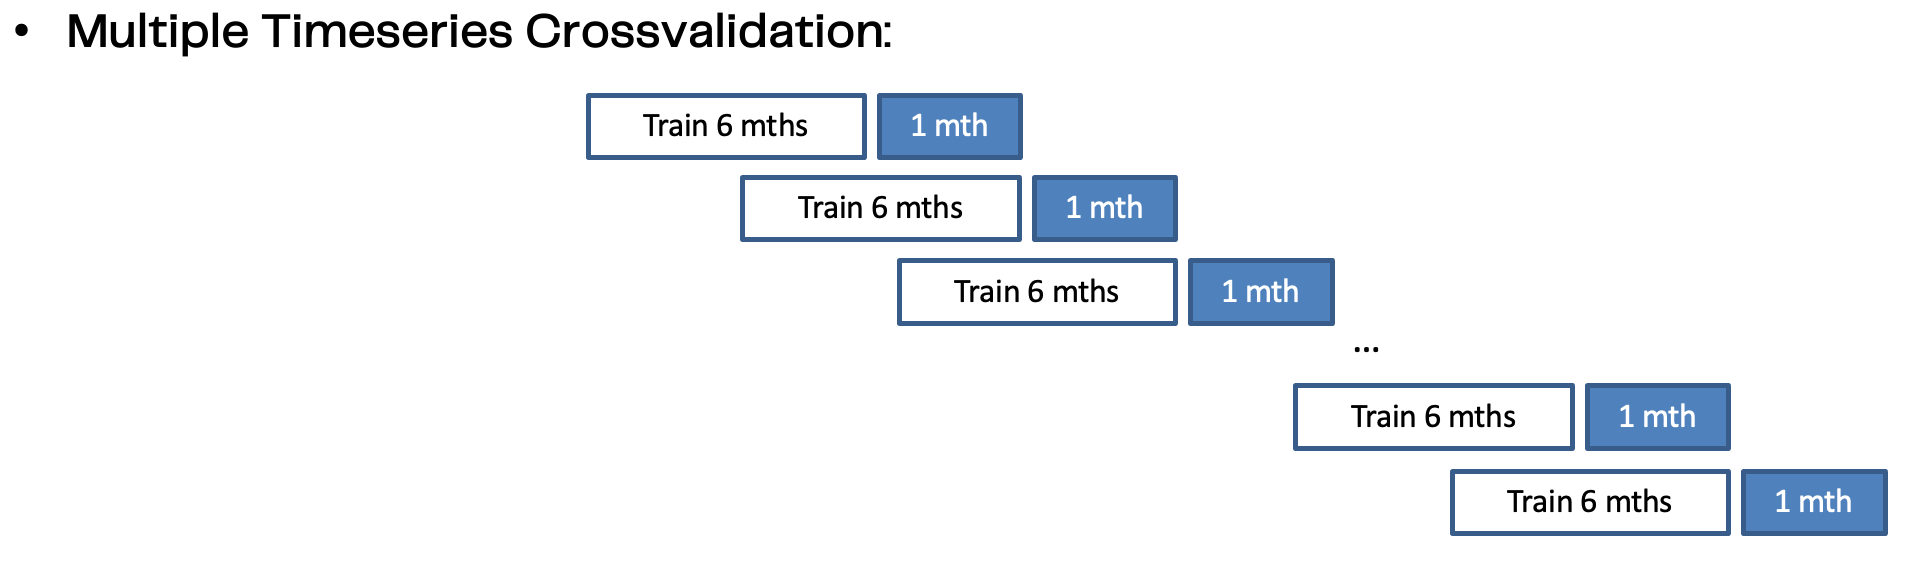

In [181]:
# fit data with size of the Multiple Timeseries Crossvalidation

data.drop(data.tail((len(data.index) - 126) % 21).index, inplace=True)

In [182]:
# split train and test data

train_day = 21 * 6  # 6 month
test_day = 21  # 1 month
num_set = (len(data.index) - 126) // 21  # num of dataset

train_set = []
test_set = []

for i in range(num_set):
    set_train = data.iloc[test_day * i : train_day + test_day * i]
    set_test = data.iloc[train_day + test_day * i : train_day + test_day * (i + 1)]
    train_set.append(set_train)
    test_set.append(set_test)

Linear Regression

1074.1144253890602
790.2598081831351
0.8098499204884038 0.1771423000836252


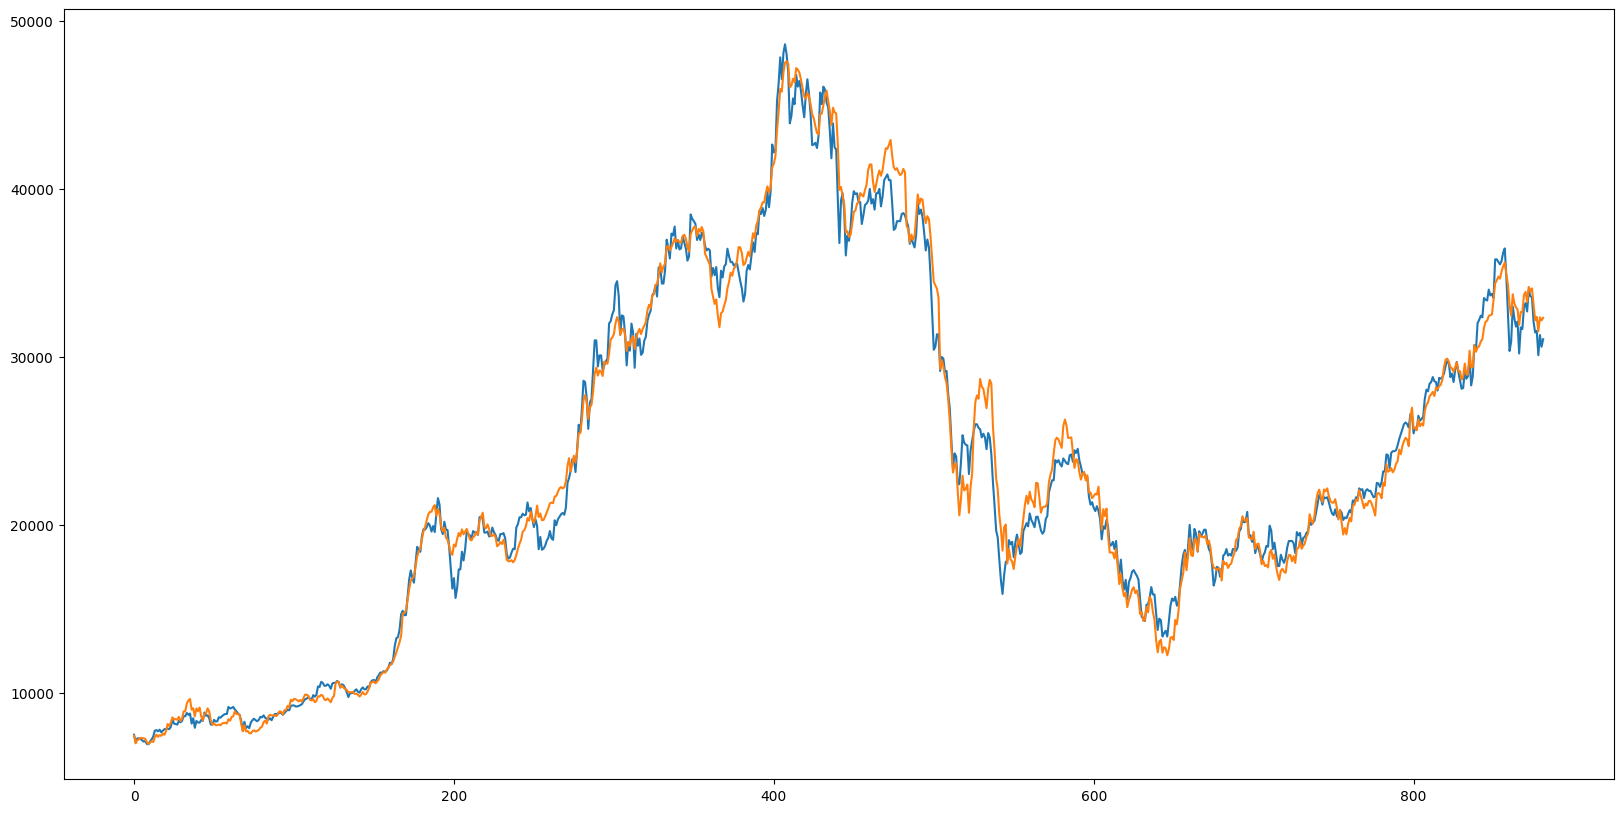

In [239]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

ic_val = []
y_test_all = []
y_pred_all = []

for i in range(num_set):
    Y_train = train_set[i]['close'].to_numpy()
    X_train = train_set[i].drop('close', axis=1).to_numpy()
    y_test = test_set[i]['close'].to_numpy()
    y_test_all.append(y_test)
    x_test = test_set[i].drop('close', axis=1).to_numpy()
    model = LinearRegression().fit(X_train, Y_train)
    y_pred = model.predict(x_test)
    y_pred_all.append(y_pred)
    spearman_corr, _ = spearmanr(y_test, y_pred)
    ic_val.append(spearman_corr)

y_test_all = np.array(y_test_all)
y_test_all = y_test_all.flatten()

y_pred_all = np.array(y_pred_all)
y_pred_all = y_pred_all.flatten()
mae = mean_absolute_error(y_test_all, y_pred_all)
rmse = np.sqrt(mean_squared_error(y_test_all, y_pred_all))

plt.figure(figsize=(20, 10))
plt.plot(y_test_all, label='Actual')
plt.plot(y_pred_all, label='Predict')

mean_ic = np.mean(ic_val)
std_ic = np.std(ic_val)

print(rmse)
print(mae)
print(mean_ic, std_ic)